In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # to scale the data.
from tensorflow.keras.models import Sequential #  to create a linear stack of layers in a neural network
# A linear stack provides a simple and efficient way to build neural networks, 
# making it particularly useful for many common tasks in machine learning and deep learning.
from tensorflow.keras.layers import Dense, LSTM, Input

In [2]:
# Load the shampoo sales data
shampoo_data = pd.read_csv("shampoo_sales.csv")
sales_values = shampoo_data['Sales'].values

# Check for NaN values
if np.any(np.isnan(sales_values)):
    print("Data contains NaN values. Please clean the data.")
    sales_values = np.nan_to_num(sales_values)  # Replace NaNs with 0 or appropriate value

# Check if the data is too small
if len(sales_values) < 2:
    raise ValueError("Not enough data points to calculate Hurst exponent and fractal dimension.")

In [4]:
sales_values

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [38]:
shampoo_data

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


In [5]:
shampoo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0375
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108     
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133     
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161     
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119     
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

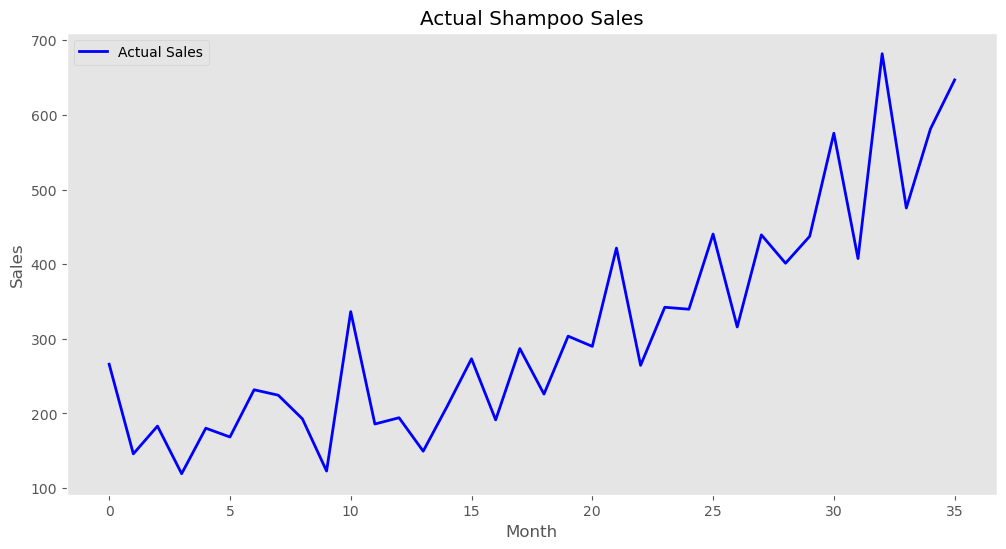

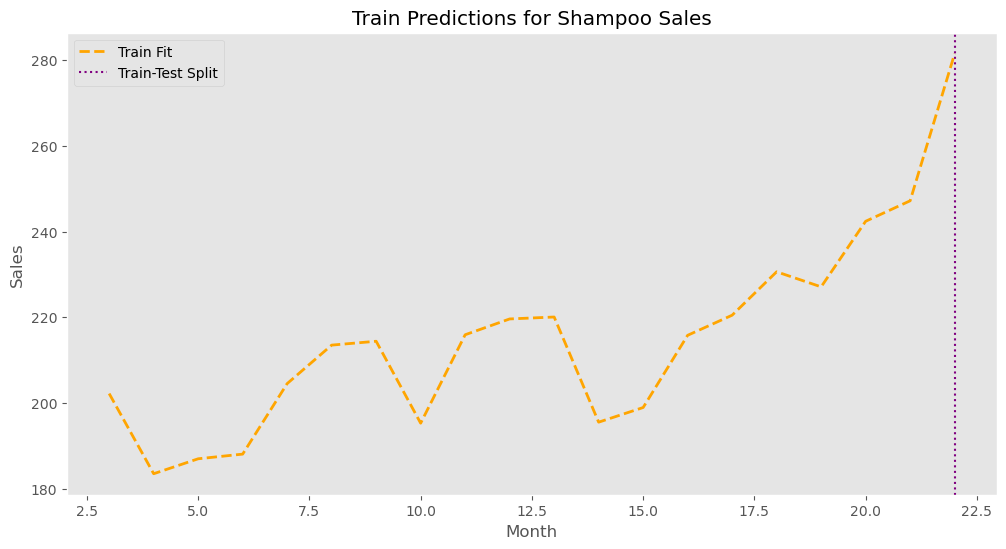

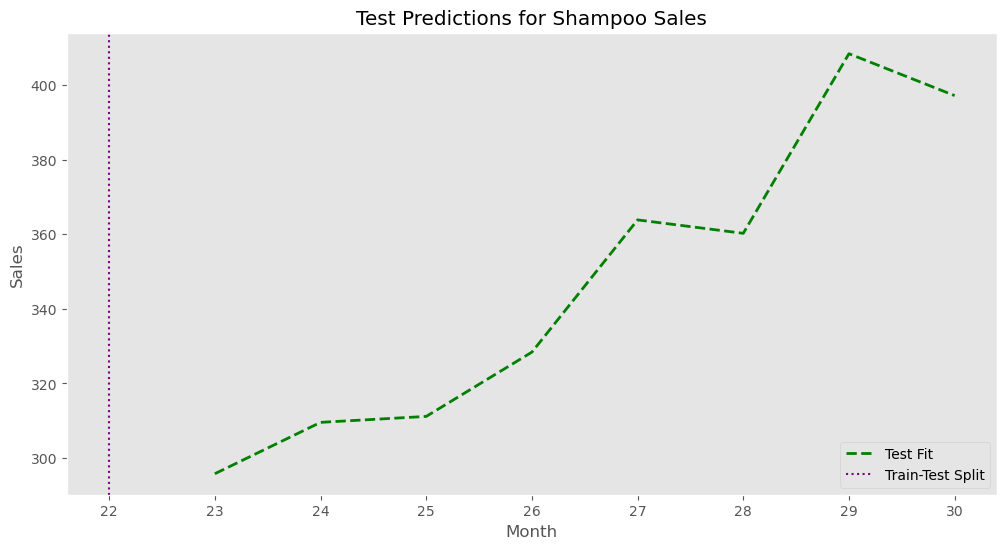

In [6]:
# Load the shampoo sales data
shampoo_data = pd.read_csv("shampoo_sales.csv")

# Normalize the data for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(shampoo_data['Sales'].values.reshape(-1, 1))
# reshape(-1, 1) is used to change the shape of the array to be two-dimensional (with one column), which is required by the MinMaxScaler.

# Split data into train (first two-thirds) and test (last third)
train_size = int(len(scaled_data) * 2 / 3)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the data with a time step of 3 months
# create_dataset function is designed to prepare time series data for use in a machine learning model, specifically for an LSTM network.
def create_dataset(dataset, time_step=3):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Generate train and test datasets
X_train, y_train = create_dataset(train_data, 3)
X_test, y_test = create_dataset(test_data, 3)

# Reshape data into [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential() # This initializes a sequential model, which is a linear stack of layers. It's suitable for building models layer-by-layer.
model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer
## Siimply window size if you remember.
# X_train.shape[1] refers to the number of time steps (previous observations) being used as input, and 1 indicates that each input feature has a single value
model.add(LSTM(50, return_sequences=True))  ## Furst Layer
# return_sequences=True means that this layer will return the full sequence of outputs for each input sequence, allowing the next LSTM layer to process these outputs.
model.add(LSTM(50, return_sequences=False))  ## Second Layer
#return_sequences=False means that this layer will return only the last output in the sequence, which is suitable for the final output of the model.
model.add(Dense(25))
# A Dense layer with 25 neurons, which serves as a hidden layer
model.add(Dense(1)) # The final Dense layer has 1 neuron, which is used for the output

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

"""
The Adam optimizer is a popular choice for training deep learning models 
due to its efficiency and ability to adaptively adjust the learning rate during training.

It combines the benefits of two other extensions of stochastic gradient descent: 
AdaGrad (which adapts the learning rate for each parameter) and RMSProp (which helps deal with non-stationary objectives).
"""

# Train the model
model.fit(X_train, y_train, epochs= 50, batch_size=1, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

"""
Inverse transforming predictions back to their original scale
ensures that the outputs of your model are useful, interpretable, and applicable to real-world scenarios.

"""

# Plot Actual Sales
plt.style.use('ggplot')  # Use a common available style
plt.figure(figsize=(12, 6))
plt.plot(shampoo_data['Sales'].values, label='Actual Sales', color='blue', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual Shampoo Sales')
plt.legend()
plt.grid()
plt.show()

# Plot Train Predictions
plt.figure(figsize=(12, 6))
plt.plot(np.arange(3, len(train_predict) + 3), train_predict[:, 0], label='Train Fit', color='orange', linestyle='--', linewidth=2)
plt.axvline(x=len(train_predict) + 2, color='purple', linestyle=':', label='Train-Test Split')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Train Predictions for Shampoo Sales')
plt.legend()
plt.grid()
plt.show()

# Plot Test Predictions
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_predict) + 3, len(train_predict) + len(test_predict) + 3), test_predict[:, 0], label='Test Fit', color='green', linestyle='--', linewidth=2)
plt.axvline(x=len(train_predict) + 2, color='purple', linestyle=':', label='Train-Test Split')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Test Predictions for Shampoo Sales')
plt.legend()
plt.grid()
plt.show()


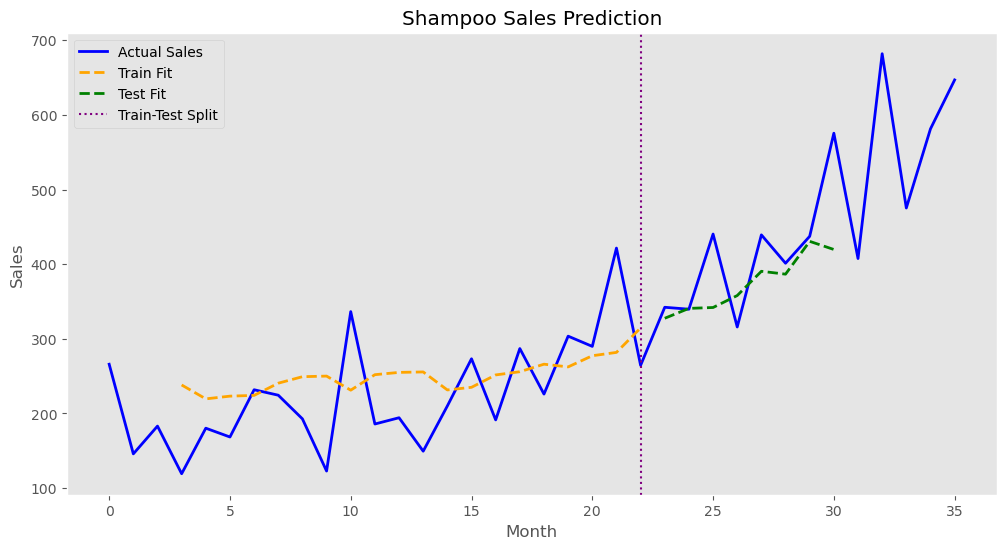

In [30]:
# Plot the results with distinct styles for actual, train, and test predictions
plt.style.use('ggplot')  # Use a common available style
train_len = len(train_predict)

plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(shampoo_data['Sales'].values, label='Actual Sales', color='blue', linewidth=2)

# Plot train predictions
plt.plot(np.arange(3, train_len + 3), train_predict[:, 0], label='Train Fit', color='orange', linestyle='--', linewidth=2)

# Plot test predictions
plt.plot(np.arange(train_len + 3, train_len + len(test_predict) + 3), test_predict[:, 0], label='Test Fit', color='green', linestyle='--', linewidth=2)

# Highlight the train-test split
plt.axvline(x=train_len + 2, color='purple', linestyle=':', label='Train-Test Split')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Shampoo Sales Prediction')
plt.legend()
plt.grid()
plt.show()


Epoch 1/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0083
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7439e-04
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5091e-04
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1782e-04
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8794e-04
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3572e-04
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7881e-04
Epoch 8/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6595e-04
Epoch 9/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9402e-04
Epoch 10/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3461e-04
Epoch 11/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1732e-04
Epoch 12/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6166e-04
Epoch 13/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4222e-04
Epoch 14/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3640e-05
Epoch

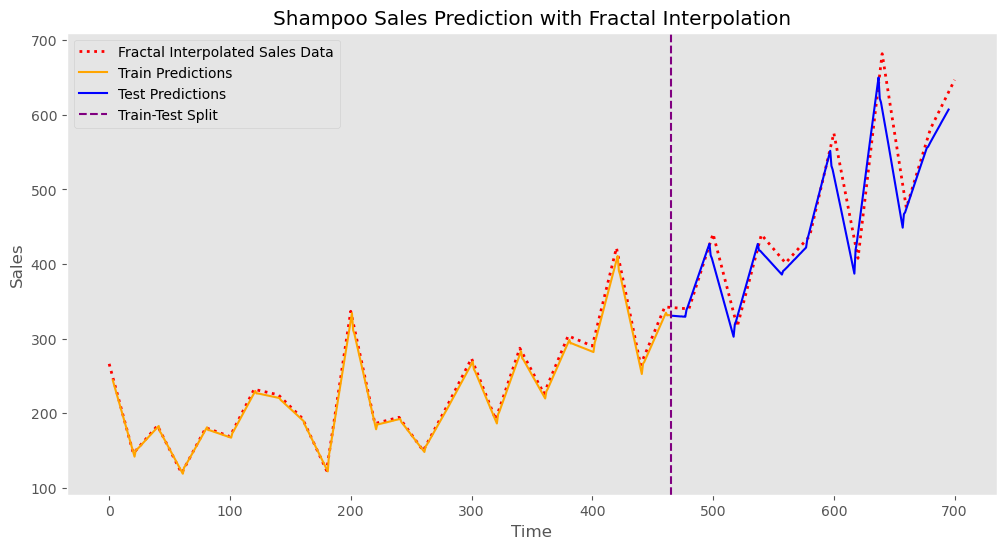

In [24]:
# Fractal interpolation function
def fractal_interpolation(data, interpolation_points=20, scaling_factor=0.5):
    interpolated_data = []
    for i in range(len(data) - 1):
        start, end = data[i], data[i + 1]
        interval = (end - start) / interpolation_points
        interpolated_data.append(start)
        
        for j in range(1, interpolation_points):
            new_point = start + j * interval + scaling_factor * (np.random.rand() - 0.5)
            interpolated_data.append(new_point)
            
    interpolated_data.append(data[-1])
# After the loop, the last data point (data[-1]) is appended to ensure the final point is included
    return np.array(interpolated_data)

"""
interpolation_points=20:
This parameter specifies how many new points should be generated between each pair of existing data points. The default is set to 20.

scaling_factor=0.5:
This factor controls the amount of random variation added to the interpolated points. A higher scaling factor would introduce more randomness.
"""

# Load and preprocess data
shampoo_data = pd.read_csv("shampoo_sales.csv")  # Ensure the file path is correct
shampoo_data['Sales'] = shampoo_data['Sales'].astype(float)
sales_data = shampoo_data['Sales'].values

# Apply fractal interpolation to make the dataset fine-grained
fine_grained_data = fractal_interpolation(sales_data, interpolation_points=20, scaling_factor=0.1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(fine_grained_data.reshape(-1, 1))

# Split data into train and test sets (2/3 train, 1/3 test)
train_size = int(len(scaled_data) * 2 / 3)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare data for LSTM
def create_dataset(dataset, time_step=3):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Generate train and test datasets
X_train, y_train = create_dataset(train_data, 3)
X_test, y_test = create_dataset(test_data, 3)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model using Input layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer to specify input shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs= 50, batch_size=1, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Plot results
plt.style.use('ggplot')  # Set a style for the plot
plt.figure(figsize=(12, 6))

# Plot fractal interpolated data as a dotted red line
plt.plot(fine_grained_data, label='Fractal Interpolated Sales Data', color='red', linestyle=':', linewidth=2)

# Plot training predictions as an orange line
train_len = len(train_predict)
plt.plot(np.arange(3, train_len + 3), train_predict[:, 0], label='Train Predictions', color='orange')

# Plot test predictions as a solid blue line
plt.plot(np.arange(train_len + 3, train_len + len(test_predict) + 3), test_predict[:, 0], label='Test Predictions', color='blue')

# Train-Test Split line
plt.axvline(x=train_len + 2, color='purple', linestyle='--', label='Train-Test Split')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Shampoo Sales Prediction with Fractal Interpolation')
plt.legend()
plt.grid()
plt.show()

In [9]:
import numpy as np
import pandas as pd

# Define the Hurst exponent function
def hurst_exponent(ts):
    """Calculate the Hurst exponent of a time series."""
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    log_lags = np.log(lags)
    log_tau = np.log(tau)
    H = np.polyfit(log_lags, log_tau, 1)[0]  # slope of the line
    return H

# Load and preprocess data (assuming data is already loaded as 'sales_data')
# Assuming fine_grained_data is generated already
H = hurst_exponent(fine_grained_data)
D = 2 - H

print(f"Hurst Exponent: {H:.4f}, Fractal Dimension: {D:.4f}")


Hurst Exponent: 0.2624, Fractal Dimension: 1.7376


Epoch 1/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0053
Epoch 2/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4428e-04
Epoch 3/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1529e-04
Epoch 4/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3393e-04
Epoch 5/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0748e-04
Epoch 6/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1666e-04
Epoch 7/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6241e-04
Epoch 8/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7403e-04
Epoch 9/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7723e-04
Epoch 10/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2762e-04
Epoch 11/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0406e-04
Epoch 12/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5056e-05
Epoch 13/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6225e-05
Epoch 14/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2455e-04
Epoch

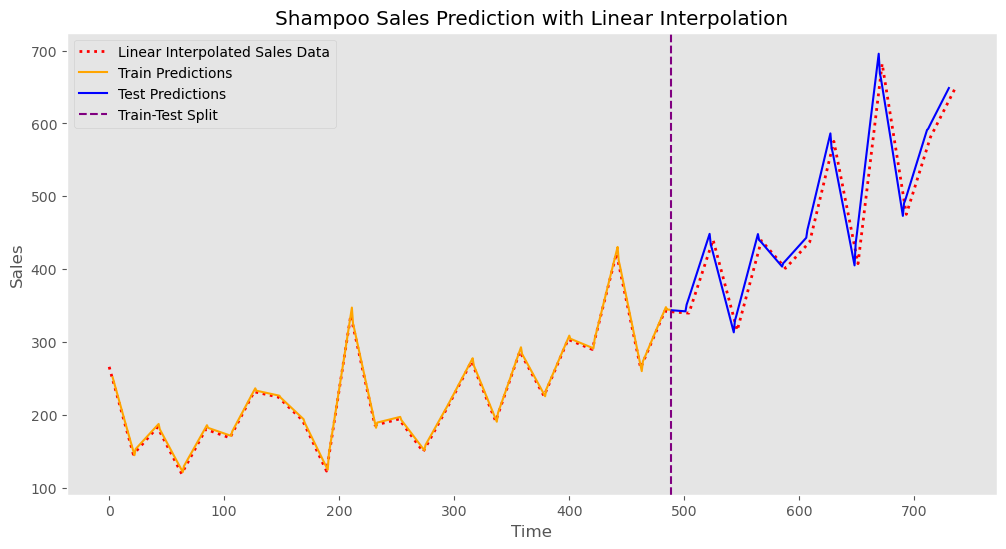

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input

# Linear interpolation function
def linear_interpolation(data, interpolation_points=20):
    interpolated_data = []
    for i in range(len(data) - 1):
        start, end = data[i], data[i + 1]
        # Calculate the interval
        interval = (end - start) / (interpolation_points + 1)
        interpolated_data.append(start)
        
        for j in range(1, interpolation_points + 1):
            new_point = start + j * interval
            interpolated_data.append(new_point)
            
    interpolated_data.append(data[-1])
    return np.array(interpolated_data)

# Load and preprocess data
shampoo_data = pd.read_csv("shampoo_sales.csv")  # Ensure the file path is correct
shampoo_data['Sales'] = shampoo_data['Sales'].astype(float)
sales_data = shampoo_data['Sales'].values

# Apply linear interpolation to make the dataset fine-grained
fine_grained_data = linear_interpolation(sales_data, interpolation_points=20)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(fine_grained_data.reshape(-1, 1))

# Split data into train and test sets (2/3 train, 1/3 test)
train_size = int(len(scaled_data) * 2 / 3)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare data for LSTM
def create_dataset(dataset, time_step=3):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Generate train and test datasets
X_train, y_train = create_dataset(train_data, 3)
X_test, y_test = create_dataset(test_data, 3)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model using Input layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer to specify input shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Plot results
plt.style.use('ggplot')  # Set a style for the plot
plt.figure(figsize=(12, 6))

# Plot linear interpolated data as a dotted red line
plt.plot(fine_grained_data, label='Linear Interpolated Sales Data', color='red', linestyle=':', linewidth=2)

# Plot training predictions as an orange line
train_len = len(train_predict)
plt.plot(np.arange(3, train_len + 3), train_predict[:, 0], label='Train Predictions', color='orange')

# Plot test predictions as a solid blue line
plt.plot(np.arange(train_len + 3, train_len + len(test_predict) + 3), test_predict[:, 0], label='Test Predictions', color='blue')

# Train-Test Split line
plt.axvline(x=train_len + 2, color='purple', linestyle='--', label='Train-Test Split')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Shampoo Sales Prediction with Linear Interpolation')
plt.legend()
plt.grid()
plt.show()

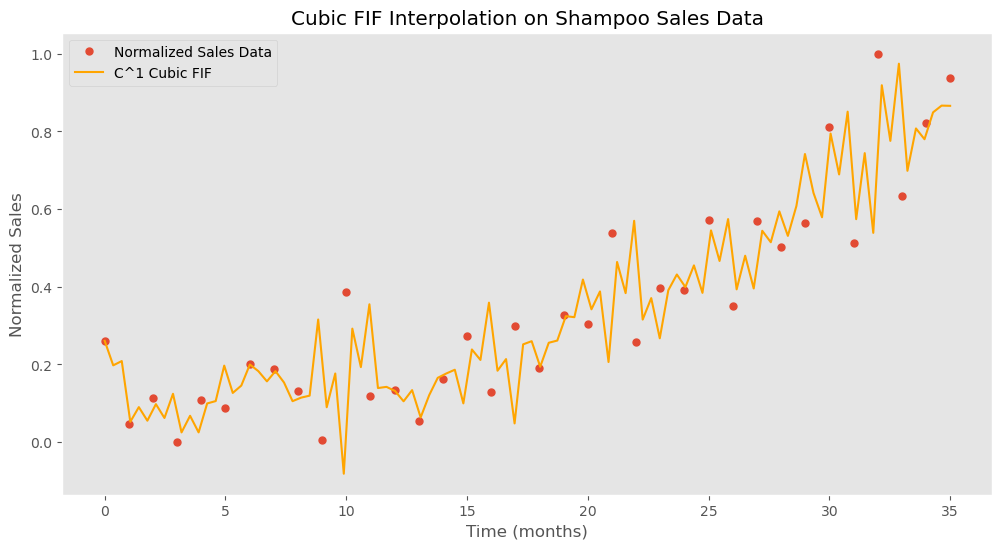

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
shampoo_data = pd.read_csv("shampoo_sales.csv")  # Ensure the file path is correct
shampoo_data['Sales'] = shampoo_data['Sales'].astype(float)
sales_data = shampoo_data['Sales'].values

# Generate x values corresponding to sales data
x = np.arange(len(sales_data))

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_data.reshape(-1, 1)).flatten()

# Cubic FIF for C^1 continuity
def cubic_fif_c1(x, y):
    n = len(x) - 1
    a = y[:-1]
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / (x[i + 1] - x[i])  # Linear coefficient
    
    # Calculate cubic coefficients based on conditions
    for i in range(1, n):
        c[i] = (b[i] - b[i - 1]) / (x[i] - x[i - 1])
    
    for i in range(n):
        d[i] = (c[i + 1] - c[i]) / (x[i + 1] - x[i]) if i < n - 1 else 0

    return a, b, c, d
    
"""
Linear Coefficient a
Quadratic Coefficient b
Cubic Coefficient d
"""

a, b, c, d = cubic_fif_c1(x, scaled_data)

# Evaluate the cubic FIF
def evaluate_cubic_fif(x_new, x, a, b, c, d):
    y_new = np.zeros_like(x_new)
    for i in range(len(x_new)):
        for j in range(len(x) - 1):
            if x[j] <= x_new[i] <= x[j + 1]:
                dx = x_new[i] - x[j]
                y_new[i] = a[j] + b[j] * dx + c[j] * dx**2 + d[j] * dx**3
                break
    return y_new

# The evaluate_cubic_fif function is designed to compute the interpolated values of the cubic spline at new x-values given the spline coefficients.

# Generate new x values for plotting
x_new = np.linspace(0, len(scaled_data) - 1, 100)

# Evaluate the C^1 cubic FIF
y_c1 = evaluate_cubic_fif(x_new, x, a, b, c, d)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(x, scaled_data, 'o', label='Normalized Sales Data', markersize=5)
plt.plot(x_new, y_c1, label='C^1 Cubic FIF', color='orange')
plt.title('Cubic FIF Interpolation on Shampoo Sales Data')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Sales')
plt.legend()
plt.grid()
plt.show()

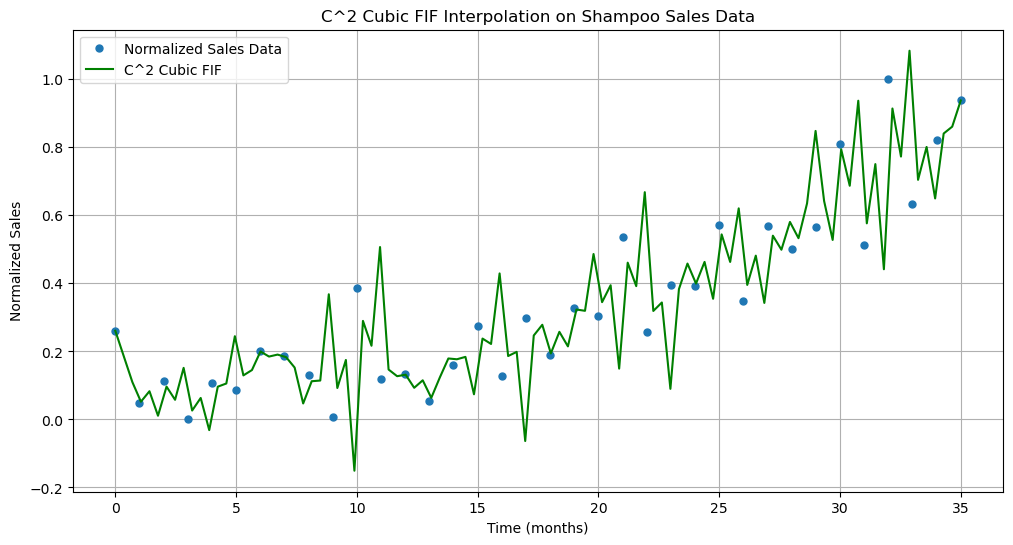

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
shampoo_data = pd.read_csv("shampoo_sales.csv")  # Ensure the file path is correct
shampoo_data['Sales'] = shampoo_data['Sales'].astype(float)
sales_data = shampoo_data['Sales'].values

# Generate x values corresponding to sales data
x = np.arange(len(sales_data))

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_data.reshape(-1, 1)).flatten()

# Cubic FIF for C^2 continuity
def cubic_fif_c2(x, y):
    n = len(x) - 1
    a = y[:-1]
    b = np.zeros(n)
    c = np.zeros(n + 1)  # +1 for the boundary condition
    d = np.zeros(n)

    # Calculate coefficients for linear terms
    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / (x[i + 1] - x[i])

    # Calculate second derivatives (natural cubic)
    h = np.diff(x)
    alpha = np.zeros(n)

    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (b[i] - b[i - 1])

    # Solve for the second derivatives
    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]

    # Back substitution
    l[n] = 1
    z[n] = 0
    c[n] = 0
    for j in range(n - 1, 0, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
        d[j] = (c[j + 1] - c[j]) / h[j]

    return a, b, c, d

# Get coefficients for C^2 cubic FIF
a, b, c, d = cubic_fif_c2(x, scaled_data)

# Evaluate the cubic FIF
def evaluate_cubic_fif(x_new, x, a, b, c, d):
    y_new = np.zeros_like(x_new)
    for i in range(len(x_new)):
        for j in range(len(x) - 1):
            if x[j] <= x_new[i] <= x[j + 1]:
                dx = x_new[i] - x[j]
                y_new[i] = (a[j] + b[j] * dx + c[j] * dx**2 + d[j] * dx**3)
                break
    return y_new

# Generate new x values for plotting
x_new = np.linspace(0, len(scaled_data) - 1, 100)

# Evaluate the C^2 cubic FIF
y_c2 = evaluate_cubic_fif(x_new, x, a, b, c, d)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(x, scaled_data, 'o', label='Normalized Sales Data', markersize=5)
plt.plot(x_new, y_c2, label='C^2 Cubic FIF', color='green')
plt.title('C^2 Cubic FIF Interpolation on Shampoo Sales Data')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Sales')
plt.legend()
plt.grid()
plt.show()

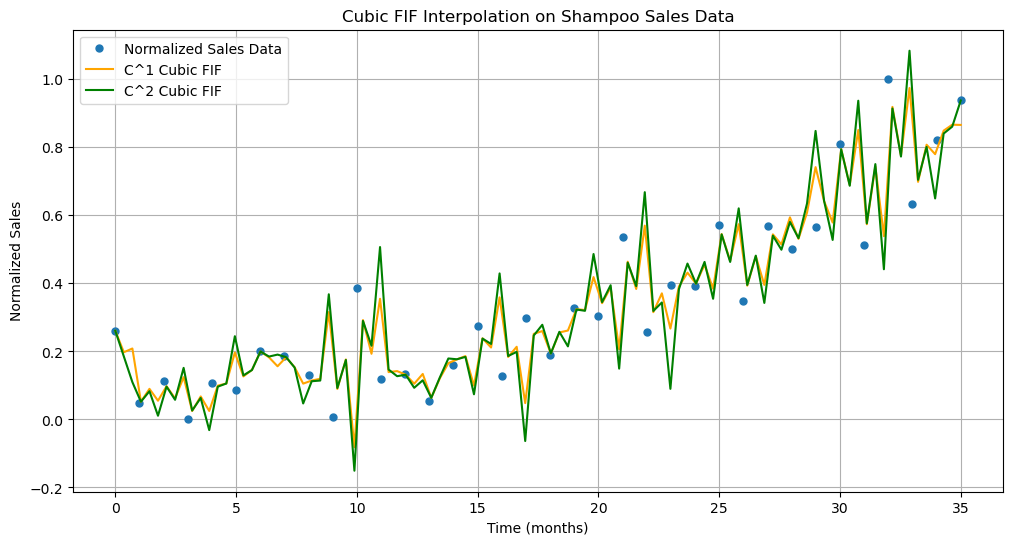

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
shampoo_data = pd.read_csv("shampoo_sales.csv")  # Ensure the file path is correct
shampoo_data['Sales'] = shampoo_data['Sales'].astype(float)
sales_data = shampoo_data['Sales'].values

# Generate x values corresponding to sales data
x = np.arange(len(sales_data))

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_data.reshape(-1, 1)).flatten()

# Cubic FIF for C^1 continuity
def cubic_fif_c1(x, y):
    n = len(x) - 1
    a = y[:-1]
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
    
    for i in range(1, n):
        c[i] = (b[i] - b[i - 1]) / (x[i] - x[i - 1])
    
    for i in range(n):
        d[i] = (c[i + 1] - c[i]) / (x[i + 1] - x[i]) if i < n - 1 else 0

    return a, b, c, d

# Cubic FIF for C^2 continuity
def cubic_fif_c2(x, y):
    n = len(x) - 1
    a = y[:-1]
    b = np.zeros(n)
    c = np.zeros(n + 1)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / (x[i + 1] - x[i])

    h = np.diff(x)
    alpha = np.zeros(n)

    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (b[i] - b[i - 1])

    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]

    l[n] = 1
    z[n] = 0
    c[n] = 0
    for j in range(n - 1, 0, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
        d[j] = (c[j + 1] - c[j]) / h[j]

    return a, b, c, d

# Evaluate the cubic FIF for C^1
def evaluate_cubic_fif_c1(x_new, x, a, b, c, d):
    y_new = np.zeros_like(x_new)
    for i in range(len(x_new)):
        for j in range(len(x) - 1):
            if x[j] <= x_new[i] <= x[j + 1]:
                dx = x_new[i] - x[j]
                y_new[i] = (a[j] + b[j] * dx + c[j] * dx**2 + d[j] * dx**3)
                break
    return y_new

# Evaluate the cubic FIF for C^2
def evaluate_cubic_fif_c2(x_new, x, a, b, c, d):
    y_new = np.zeros_like(x_new)
    for i in range(len(x_new)):
        for j in range(len(x) - 1):
            if x[j] <= x_new[i] <= x[j + 1]:
                dx = x_new[i] - x[j]
                y_new[i] = (a[j] + b[j] * dx + c[j] * dx**2 + d[j] * dx**3)
                break
    return y_new

# Generate new x values for plotting
x_new = np.linspace(0, len(scaled_data) - 1, 100)

# Get coefficients for both C^1 and C^2 cubic FIFs
a_c1, b_c1, c_c1, d_c1 = cubic_fif_c1(x, scaled_data)
a_c2, b_c2, c_c2, d_c2 = cubic_fif_c2(x, scaled_data)

# Evaluate the C^1 and C^2 cubic FIFs
y_c1 = evaluate_cubic_fif_c1(x_new, x, a_c1, b_c1, c_c1, d_c1)
y_c2 = evaluate_cubic_fif_c2(x_new, x, a_c2, b_c2, c_c2, d_c2)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(x, scaled_data, 'o', label='Normalized Sales Data', markersize=5)
plt.plot(x_new, y_c1, label='C^1 Cubic FIF', color='orange')
plt.plot(x_new, y_c2, label='C^2 Cubic FIF', color='green')
plt.title('Cubic FIF Interpolation on Shampoo Sales Data')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Sales')
plt.legend()
plt.grid()
plt.show()